<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> HW #2: ARIMAX, Compositions, NN

<span style="color:red; font-size: 14pt;"> Дедлайн 06.10.2018 23:59 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>


<span style="color:blue; font-size: 12pt">Radoslav Neychev </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">neychev@phystech.edu</span>

**Дополнительный материал для выполнения дз**:
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- 

**Оформление дз**: 
- Выполненное задание требуется отправлять через <a href='https://goo.gl/forms/XPSIbwp7wPxB4SsI3'>форму </a>
    - <span style="color:red; font-size: 20pt">ВНИМАНИЕ: для отправки задания потребуется почта в домене gmail.com или phystech.edu</span> 
- Выполненное дз прикрепляйте в формате файла ``<фамилия>_<группа>_task<номер>.ipynb``, например: ``ivanov_594_task1.ipynb`` 

**Вопросы**:
- Вопросы присылайте на почту ml.course.mipt@gmail.com
- Укажите тему письма в следующем формате ``ML2018_fall_Question_<Тема вопроса>``

--------
- **PS1**: Будьте внимательны при заполнении формы, когда отправляете ДЗ 


<h1 align="center">Теоретическая часть (20%)</h1> 

При ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам.

---

**Вопрос 1 (4%)**  Напишите уравнение временного ряда (в виде $y_t=f\left(y_{t-1}, \dots, y_1,~\varepsilon_{t},\dots, \varepsilon_{1}\right)$) которая соответствует модели:
   * 1) ARIMA $(p=1,d=k,q=0)$,
     - <Ответ>
   * 2) ARIMA $(p=1,d=k+1,d=0)(P=0, D=1, Q=1)_s$,
     - <Ответ>
--- 
**Вопрос 2 (4%)**   
   * 1) Опишите ситуацию (аргументированно), в котором композиция Adaptive Composition будет прогнозировать хуже, чем лучший из базовых алгоритмов.
    - <Ответ>
   * 2) Опишите ситуацию (аргументированно), в котором композиция Adaptive Selection будет прогнозировать хуже, чем лучший из базовых алгоритмов.
    - <Ответ>

---

**Вопрос 3 (6%)** Покажите, что ARIMA$(p=1,d=2, q=2)$ эквивалентна модели ЭС с линейным затухающим трендом (damped-trend linear exponential smoothing ) при условиях:
		$$(1-\phi B)(1-B)Y_t = (1-\theta_1 B-\theta_2 B^2)\epsilon_t$$
		$$\theta_1 = 1+\phi-\alpha-\alpha\beta\phi, \text{ } \theta_2 = (\alpha-1)\phi$$
        $\phi$~--- coefficient of damped trend.

---        

**Вопрос 4 (6%)**: Покажите, что для модели  
    $$AR(p)\colon \;\;\; y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t,$$  
    где $y_t$ стационарный процесс с нулевым средним,$~~$
    $\phi_1,\dots,\phi_p$ - константы ($\phi_p \neq 0$), $~~$
    $\varepsilon_t$ несмещённый гауссовский шум с дисперсией $\sigma_\varepsilon^2 $
выполнено:

  * 1) частный коэффициент автокорреляции
   $$\phi_{\tau\tau} = \mathsf{E}[y_t-\hat y_t, y_{t+\tau} - \hat y_{t+\tau}]= \begin{cases}0 &, \tau>p; \\ f(\tau,p)>0 &, 0\leq\tau\leq p. \end{cases}$$
	
  где $\hat y_t$ - прогноз $y_t$ согласно следующей регрессионной модели $$y_t = \sum_{j=1}^{\tau-1}\beta_j y_{t+j}$$
    $\hat y_{t+\tau}$ - прогноз $y_{t\tau}$ согласно следующей регрессионной модели $$y_{t+\tau} = \sum_{j=1}^{\tau-1}\gamma_j y_{t+j}.$$

<Ответ>

<h1 align="center">Практическая часть I (30%)</h1>
Требуется проанализировать временной ряд и спрогнозировать его моделю ARIMA. 
Каждый студент прогнозирует свой собсвтенный временной ряд, соответствующий ВР нужно смотреть на листе HW2_TS <a href="https://docs.google.com/spreadsheets/d/188zdwJ1onHseMCvtRK3_uh6WW8prHssoiZ9l-_Mfk0M/edit#gid=1703509799">здесь</a>. 

(Каждый из нижеследующих пунктов задания оценивается в 3% от общего веса задания).

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

%matplotlib inline

* 0) read data for TS under consideration and use the first 80% of all length of the TS as train TS.  

In [226]:
employment_ts = pd.read_csv('wisconsin-employment-time-series.csv', 
            sep=',', 
            decimal='.', 
            parse_dates=True, 
            dayfirst=True, 
            index_col='Date')
employment_ts.index.names=['Timestamp']
employment_ts.head()

,Employment rate
Timestamp,
1961-01-01,56.3
1961-02-01,55.7
1961-03-01,55.8
1961-04-01,56.3
1961-05-01,57.2


* 1) plot the graph of the train TS, preprocess data (delete tail, make calendar transformation if needed)

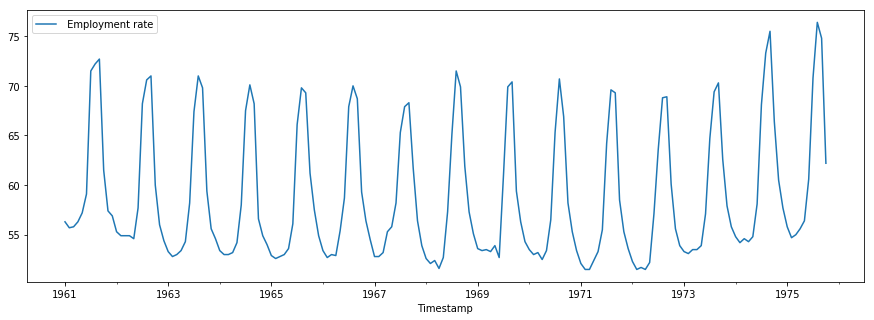

In [227]:
employment_ts.plot(figsize=(15,5))

* 2) stabilize dispersion of the train TS through box-cox transformation if needed.

Судя по графику преобразование Бокса-Кокса не нужно

* 3) if the transformed train TS is non-stationary make it stationary (remember the power of differencing $d$).

Продифференцируем с периодом 12.

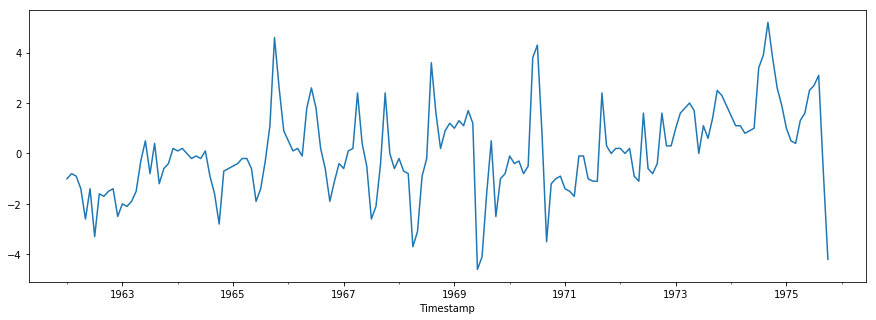

In [228]:
p = 12
employment_ts_d12 = deepcopy(employment_ts)
employment_ts_d12['diff12'] = (employment_ts - employment_ts.shift(p))[p:]
employment_ts_d12['diff12'].plot(figsize=(15,5))

И еще раз с p = 1

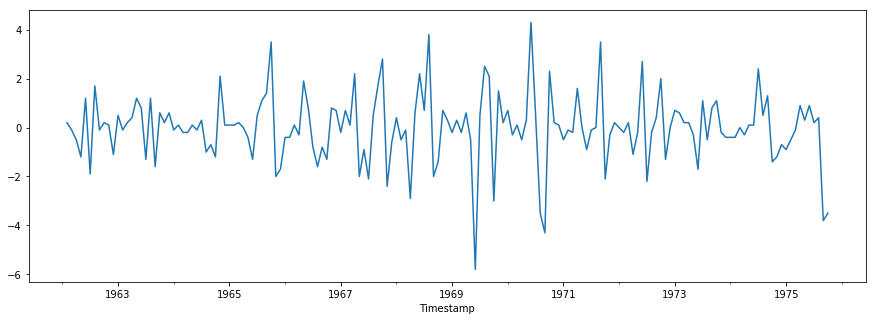

In [229]:
p = 1
employment_ts_d12_d1 = deepcopy(employment_ts)
employment_ts_d12_d1['diff'] = (employment_ts_d12['diff12'] - employment_ts_d12['diff12'].shift(p))[p:]
employment_ts_d12_d1['diff'].plot(figsize=(15,5))

Так как shift просто забивает часть таблицы NaN то для статистики отсечем эту часть 

In [230]:
stats_array = employment_ts_d12_d1['diff'][13:]

In [231]:
kpss_stat= stattools.kpss(stats_array)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


The KPSS test statistic 0.148696, 
pvalue: 0.10 
maximal Lag: 14 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [232]:
df_stat = stattools.adfuller(stats_array)
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -5.321176, 
pvalue: 0.00 
maximal Lag: 14 
critical values: {'1%': -3.474714913481481, '5%': -2.881008708148148, '10%': -2.5771508444444446}


* 4) plot ACF/PACF for  the transformed train TS in order to understand whether $AR(p)/MA(q)$ may be used.

In [255]:
col_name = ' Employment rate'
data = employment_ts[[col_name]].dropna()

C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


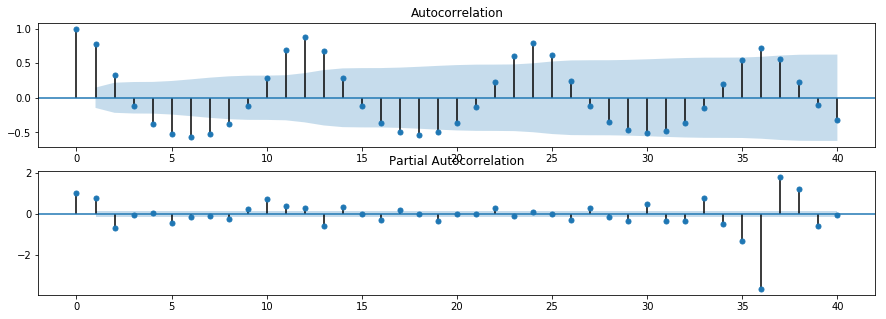

In [256]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data[col_name].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data[col_name].values.squeeze(), lags=40, ax=ax2)

Кандидаты:

q ~ 0, 1, 2, 4, 5, 6, 7, 8, 11

p ~ 0, 1, 2, 5, 8, 9, 10, 11 

* 5) select set of candidate parameters for ARMA (for the train TS)

In [257]:
data = employment_ts[col_name]
print(data.shape)

(178,)


In [258]:
train = data[:140]
test = data[140:]

* 6) train candidate ARIMA models (use $d$ from step 3), $p$, $q$ from step 5)), compare their AIC, choose the best model.

In [259]:
models_list = []

In [260]:
def try_fit(ts, p,d,q,P,D,Q): 
    try:
        mod = sm.tsa.statespace.SARIMAX(ts, order=(p,d,q), seasonal_order=(P,D,Q,12))
        results = mod.fit()
        models_list.append(((p,d,q,P,D,Q), results.aic, results.bic, results.hqic, results))
    except Exception:
        return ("sarimax_%i%i%i_%i%i%i: can't fit model " % (p,d,q,P,D,Q))

In [261]:
from sklearn.grid_search import ParameterGrid
param_grid = {'p': [0, 1, 2, 5, 8, 9, 10, 11 ], 'd' : [1],
             'q': [0, 1, 2, 5, 8, 9, 10, 11 ], 'P' : [1],
             'D': [1], 'Q' : [1]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(try_fit(train, params['p'], params['d'], params['q'], params['P'], params['D'], params['Q']))

C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_0110_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_111_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_1110_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_211_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_2110_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_512_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_515_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_5110_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_815_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_8111_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_915_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_9111_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_1015_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_10110_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_10111_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_1115_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


None


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_1119_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_11110_111: can't fit model 


C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


sarimax_11111_111: can't fit model 


In [262]:
models_list.sort(key=lambda x: x[1])
print(models_list[0])
models_list.sort(key=lambda x: x[2])
print(models_list[0])
models_list.sort(key=lambda x: x[3])
print(models_list[0])

((1, 1, 2, 1, 1, 1), 402.103227210428, 419.1683497291795, 409.0365805774609, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000023213962400>)
((0, 1, 2, 1, 1, 1), 402.5101982023781, 416.73113363467104, 408.2879926749055, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000023218A52CF8>)
((0, 1, 2, 1, 1, 1), 402.5101982023781, 416.73113363467104, 408.2879926749055, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x0000023218A52CF8>)


* 7) check test for unbiasedness, stationarity and non-autocorrelation of the residuals of the best ARIMA model; if the tests fail you need to review your choice.

Рассмотрим остатки на части датасета, которую не смяло дифференцированием

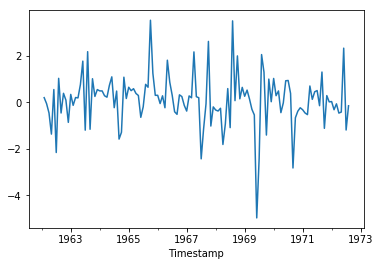

In [275]:
sarima_121_111 = models_list[0][4]
sarima_121_111.resid[train_start:train_end].plot()

C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


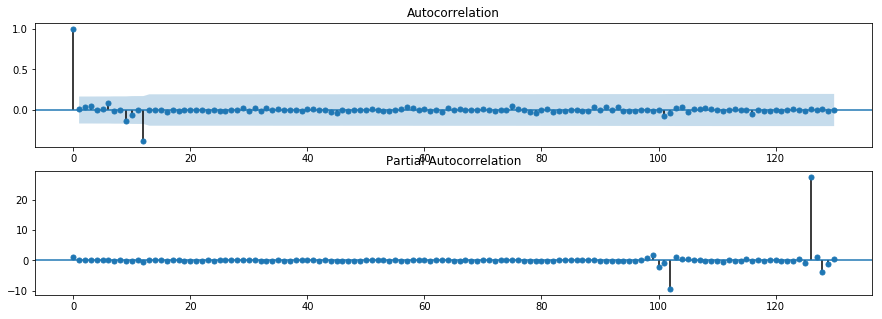

In [276]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_121_111.resid.values.squeeze(), lags=130, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_121_111.resid.values.squeeze(), lags=130, ax=ax2)

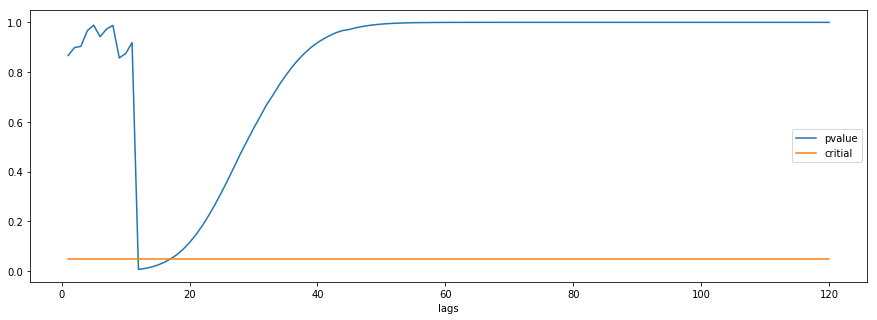

In [277]:
pd.DataFrame({'lags':range(1,121,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(sarima_012_111.resid.values, lags=120)[1], 
              'critial':np.array([0.05]*120)}).set_index('lags').plot(figsize=(15,5))

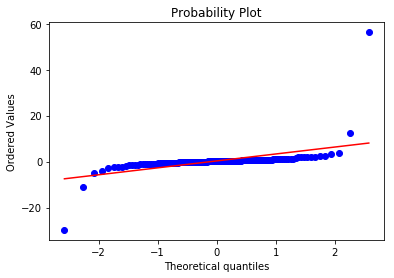

In [278]:
sps.normaltest(sarima_121_111.resid)
fig = plt.figure()
res = sps.probplot(sarima_121_111.resid, dist="norm", plot=pylab)

In [279]:
kpss_stat= stattools.kpss(sarima_121_111.resid)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

C:\Users\DmRodin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


The KPSS test statistic 0.122181, 
pvalue: 0.10 
maximal Lag: 14 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Получили, что ряд остатков стационарен, не смещен, не коррелирует и вроде даже почти нормален.

* 8) build forecast for the initial TS (you need to transform it like in step 2)

In [280]:
train_start = '1962-02-01'
train_end = '1972-08-01'

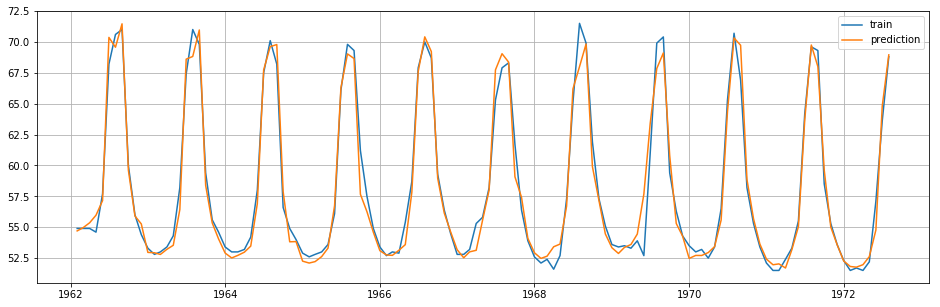

In [282]:
prediction = sarima_121_111.predict(start=train_start, end=train_end)
train_clipped = train[train_start:train_end]

plt.figure(figsize=(16,5))
plt.grid()
plt.plot(train_clipped, label='train')
plt.plot(prediction, label='prediction')
plt.legend()
plt.show()

* 9) build forecast interval for the last 20% of the transformed initial TS. Calculate loss MACAPE of your forecast. Does the forecast look appropriate?

In [283]:
test_start = '1972-09-01'
test_end = '1975-10-01'

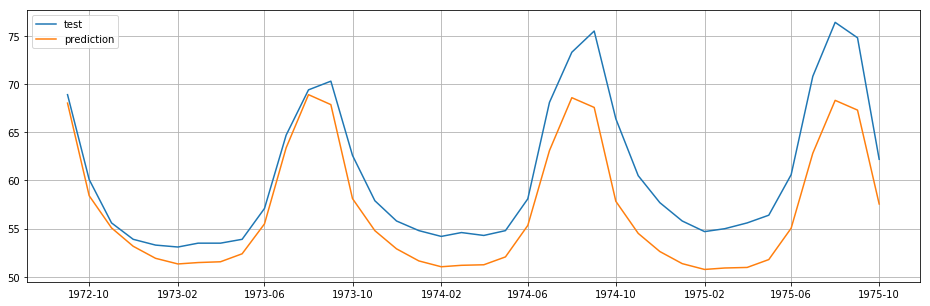

In [284]:
prediction = sarima_121_111.predict(start=test_start, end=test_end)

plt.figure(figsize=(16,5))
plt.grid()
plt.plot(data[test_start : test_end], label='test')
plt.plot(prediction, label='prediction')
plt.legend()
plt.show()

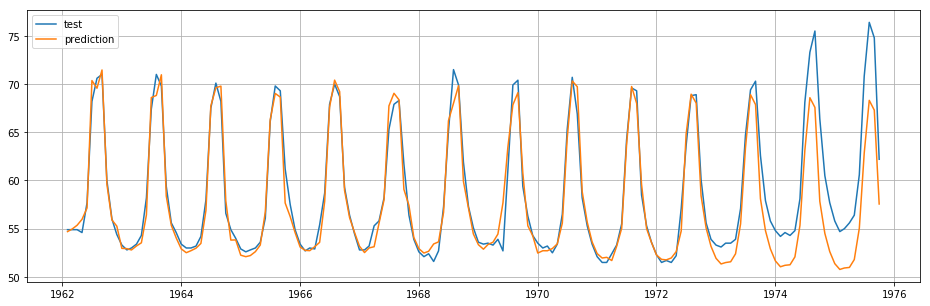

In [285]:
prediction = sarima_121_111.predict(start=train_start, end=test_end)

plt.figure(figsize=(16,5))
plt.grid()
plt.plot(data[train_start : test_end], label='test')
plt.plot(prediction, label='prediction')
plt.legend()
plt.show()

In [273]:
def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [274]:
prediction = sarima_012_111.predict(start=test_start, end=test_end)
print(qualityMACAPE(data[test_start : test_end], prediction)[0])

0.06168407916964759


**Вывод** На тестовой части появился тренд, которого не было в обучении. Так что предсказание получилось заниженным. Трейновую часть модель предсказывает хорошо.

<h1 align="center">Практическая часть II (50%)</h1> 
Мы будем решать достаточно классическую задачу классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [9]:
import os
import pylab

In [10]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

In [11]:
y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

In [12]:
legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

In [13]:
from sklearn.decomposition import PCA
pca = PCA()

In [14]:
X_train_pca = pca.fit_transform(X_train_with_engineered_features)

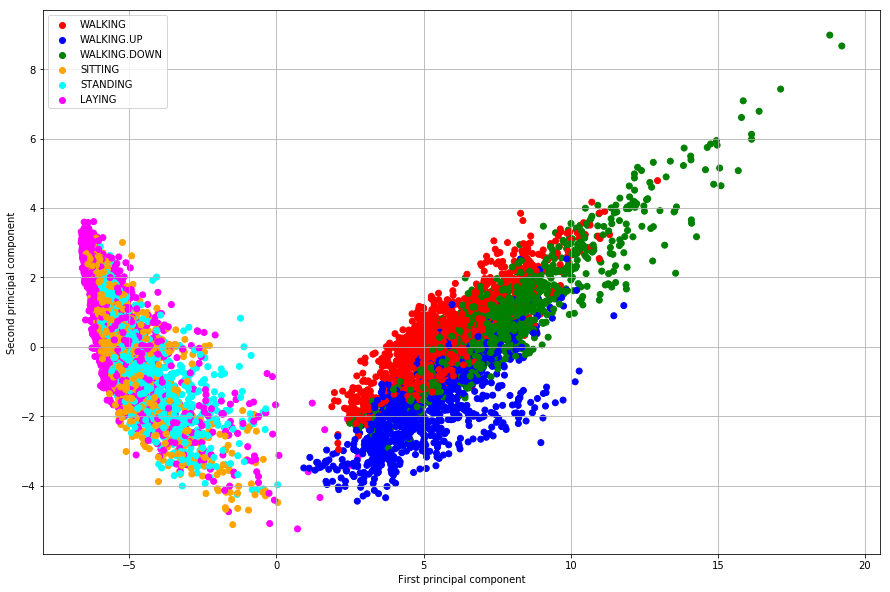

In [15]:
plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

### Часть 0. Разогрев. 
Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

### Часть 1. Предобработка данных.
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition).

In [16]:
import os

In [17]:
os.path.join('data', 'etc', 'file1.asdas')

'data\\etc\\file1.asdas'

In [18]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [19]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


### Часть 2. Построение сети и эксперименты. (50% +)
Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 80%. Это может оказаться нетривиальной задачей, поэтому трезво оценивайте свои силы. 

__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи задача была решена благодаря ..."

Базовая модель построена с использованием библиотеки `keras` для вас. Вы можете использовать любой знакомый вам фреймворк. Удачи в экспериментах. 

__Bonus__: при достижении 85% accuracy - 25% бонусных баллов, при достижении 89% accuracy - 50% бонусных баллов (т.е. ещё 25%).

In [20]:
import keras

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, SimpleRNN, Embedding, Reshape
from keras.utils import to_categorical
from keras import regularizers
from keras_tqdm import TQDMNotebookCallback

In [22]:
#Create model
model = Sequential()
model.add(LSTM(units=16, activation='relu',
               input_shape=(128, 9)))    # the batch size is neglected!
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________


Метки классов стоит перевести в one-hot-encoded формат (теперь это векторы вероятностей принадлежности классу). 

In [24]:
def one_hot_encode(y, n_classes):
    return keras.utils.to_categorical(y, num_classes=n_classes)

In [25]:
y_train_one_hot = one_hot_encode(y_train, 6)
y_test_one_hot = one_hot_encode(y_test, 6)

In [26]:
model.fit(X_train, y_train_one_hot, batch_size=128, epochs=20, verbose=0, callbacks=[TQDMNotebookCallback()])

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
accuracy_score(y_test, model.predict_classes(X_test))

0.40380047505938244

In [29]:
import keras as k

In [30]:
class evalCallback(k.callbacks.Callback):
    def __init__(self):
        self.epoch_acc = []
        self.train_acc = []
        self.test_acc = []
        self.max_acc = -1.0
    
    def on_batch_end(self, batch, logs):
        self.epoch_acc.append(logs['acc'])
    
    def on_epoch_end(self, epoch, logs):
        self.train_acc.append(np.mean(self.epoch_acc))
        self.epoch_acc = []
        name = 'model_' + str(len(self.test_acc)) + '.h5'
        acc = accuracy_score(y_test, np.argmax(self.model.predict(X_test), axis = 1))
        self.test_acc.append(acc)
        if acc > self.max_acc:
            self.model.save(name)
            self.max_acc = acc
        print(epoch, acc)

In [60]:
model_1_input = k.Input(shape=(None, 9), name='main_input')
x = k.layers.LSTM(units=64, activation='relu', name='lstm', kernel_regularizer=k.regularizers.l2(0.00001))(model_1_input)
x = k.layers.BatchNormalization(name='norm_1')(x)
x = k.layers.Dense(units=128, activation='relu', name='dense_1')(x)
x = k.layers.BatchNormalization(name='norm_2')(x)
model_1_output = k.layers.Dense(units=6, activation='softmax', name='main_output')(x)
model_1 = k.models.Model(model_1_input, model_1_output)

In [61]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, None, 9)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                18944     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 128)               512       
_________________________________________________________________
main_output (Dense)          (None, 6)                 774       
Total params: 28,806
Trainable params: 28,422
Non-trainable params: 384
_________________________________________________________________


In [62]:
model_1.compile(loss='categorical_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy'])
cb = evalCallback()

In [73]:
model_1.fit(X_train, 
            y_train_one_hot, 
            batch_size=512, 
            epochs=120, 
            verbose=0, 
            callbacks=[TQDMNotebookCallback(), cb])

0 0.8666440447913132


1 0.8768238887003733


2 0.8683406854428232


3 0.8771632168306752


4 0.8948082796063793


5 0.8734306073973532


6 0.8995588734306074


7 0.8785205293518833


8 0.8547675602307431


9 0.8510349507974211


10 0.8788598574821853


11 0.8822531387852053


12 0.8836104513064132


13 0.8758059043094673


14 0.8931116389548693


15 0.8971835765184933


16 0.8968442483881914


17 0.8795385137427892


18 0.8866644044791313


19 0.8887003732609433


20 0.9056667797760435


21 0.8778418730912793


22 0.8771632168306752


23 0.8968442483881914


24 0.8696979979640312


25 0.8873430607397353


26 0.8866644044791313


27 0.8992195453003053


28 0.8632507634882932


29 0.8842891075670173


30 0.8707159823549372


31 0.8771632168306752


32 0.8846284356973193


33 0.8544282321004412


34 0.836104513064133


35 0.837122497455039


36 0.8808958262639973


37 0.8825924669155073


38 0.8914149983033594


39 0.8829317950458093


40 0.8819138106549033


41 0.8544282321004412


42 0.8798778418730913


43 0.8971835765184933


44 0.8686800135731252


45 0.8815744825246012


46 0.8734306073973532


47 0.8887003732609433


48 0.8853070919579233


49 0.8520529351883271


50 0.8839497794367153


51 0.8778418730912793


52 0.8873430607397353


53 0.8829317950458093


54 0.8615541228367831


55 0.8890397013912453


56 0.8887003732609433


57 0.8680013573125213


58 0.8639294197488971


59 0.8788598574821853


60 0.8781812012215813


61 0.8473023413640991


62 0.8836104513064132


63 0.8866644044791313


64 0.8588394977943672


65 0.8720732948761453


66 0.8931116389548693


67 0.8798778418730913


68 0.8808958262639973


69 0.8812351543942993


70 0.8822531387852053


71 0.8982015609093994


72 0.8829317950458093


73 0.8958262639972854


74 0.8907363420427553


75 0.8842891075670173


76 0.8829317950458093


77 0.8842891075670173


78 0.8778418730912793


79 0.8696979979640312


80 0.8686800135731252


81 0.8897183576518494


82 0.8907363420427553


83 0.8808958262639973


84 0.8846284356973193


85 0.8870037326094333


86 0.8982015609093994


87 0.8788598574821853


88 0.8663047166610112


89 0.835086528673227


90 0.8785205293518833


91 0.8948082796063793


92 0.8758059043094673


93 0.8669833729216152


94 0.8941296233457754


95 0.8948082796063793


96 0.8839497794367153


97 0.8673227010519172


98 0.8778418730912793


99 0.8527315914489311


100 0.8768238887003733


101 0.8808958262639973


102 0.8900576857821514


103 0.8473023413640991


104 0.8717339667458432


105 0.8812351543942993


106 0.8666440447913132


107 0.8808958262639973


108 0.8788598574821853


109 0.8724126230064473


110 0.8863250763488293


111 0.8795385137427892


112 0.8985408890397014


113 0.8717339667458432


114 0.8958262639972854


115 0.8951476077366813


116 0.841533763148965


117 0.8931116389548693


118 0.8971835765184933


119 0.8948082796063793


0.9070240922972514


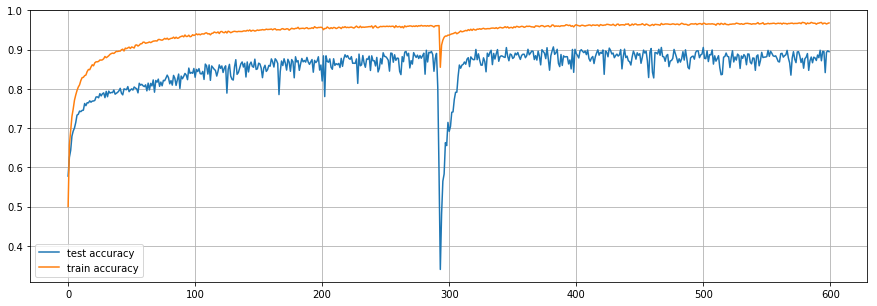

In [224]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(cb.test_acc, label='test accuracy')
plt.plot(cb.train_acc, label = 'train accuracy')
plt.legend()
print(np.max(cb.test_acc))

In [75]:
accuracy_score(y_test, np.argmax(model_1.predict(X_test), axis = 1))

0.8948082796063793

_Ваш отчет здесь_

**Идея 1** Сделать нейронку чуть сложнее, запустить сбор статистики с колбека и пообучать эпох 600.

Результат: 0.9070240922972514 максимум на тесте. Сложности нейронки не хватило на запоминание всей тестовой выборки. Скорее всего можно получить результат и лучше.